In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr
import numpy as np



ЗАДАНИЕ 1

Загружаем данные

In [2]:
df = pd.read_csv('Dataset_AB_TEST.csv', sep = ';')

Познакомимся с таблицей (выборочно первые 5 строк)

In [3]:
df.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14


Создадим копию для последующей работы

In [4]:
dfs = df.copy()
dfs

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199.0,8
1,1390221,control,1267.0,1182.0,11
2,1363404,control,4259.0,1178.0,2
3,1370042,test,7211.0,1179.0,3
4,1360376,control,760.0,1178.0,14
...,...,...,...,...,...
10971,1359021,control,799.0,1178.0,3
10972,1363347,control,4825.0,1178.0,6
10973,1373031,test,673.0,1179.0,1
10974,1370292,test,1120.0,1179.0,1


Проверим на наличие дубликатов

In [5]:
dfs.duplicated().sum()

0

Посмотрим сводную информацию

In [6]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10976 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10976 non-null  int64  
 1   id_group    10902 non-null  object 
 2   sum_pay     10849 non-null  float64
 3   id_point    10895 non-null  float64
 4   months_reg  10976 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 428.9+ KB


Проверим количество нулевых значений в столбцах

In [7]:
dfs.isnull().sum()

id_client       0
id_group       74
sum_pay       127
id_point       81
months_reg      0
dtype: int64

Видим нулевые значенияв следующих столбцах: id_group, sum_pay, id_point. замена этих позиций на средние значения не корректна. И количество нулевых значений не критично, поэтому принимаем решение удалить нулевые значения.

In [8]:
dfs = dfs.dropna()

In [9]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10840 non-null  int64  
 1   id_group    10840 non-null  object 
 2   sum_pay     10840 non-null  float64
 3   id_point    10840 non-null  float64
 4   months_reg  10840 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 508.1+ KB


Выведем группировку по торговым точкам и проверим количество наблюдений. Торговая точка № 1199 не имеет наблюдений в control, поэтому ее можно не учитывать в АБ тестировании. А № 1188 имеет маленькое количество наблюдений 6 и 4 по группам, этого количества наблюдений недостаточно для принятия каких либо решений, также можно исключить.

In [10]:
dfs.groupby(['id_point', 'id_group']).count()

id_client  sum_pay  months_reg
id_point id_group                                
1178.0   control        2403     2403        2403
         test           2407     2407        2407
1179.0   control        1716     1716        1716
         test           1755     1755        1755
1182.0   control        1023     1023        1023
         test            987      987         987
1186.0   control          23       23          23
         test             40       40          40
1188.0   control           6        6           6
         test              4        4           4
1199.0   test            476      476         476

Исключим из теста торговую точку № 1199

In [11]:
dfs = dfs.loc[dfs['id_point']!= 1199 ]

In [12]:
dfs.groupby(['id_point', 'id_group']).count()

id_client  sum_pay  months_reg
id_point id_group                                
1178.0   control        2403     2403        2403
         test           2407     2407        2407
1179.0   control        1716     1716        1716
         test           1755     1755        1755
1182.0   control        1023     1023        1023
         test            987      987         987
1186.0   control          23       23          23
         test             40       40          40
1188.0   control           6        6           6
         test              4        4           4

In [13]:
dfs['sum_pay'].describe()

count    10364.000000
mean      3553.137688
std       2967.770563
min         59.000000
25%       1202.000000
50%       3146.500000
75%       5344.000000
max      24797.000000
Name: sum_pay, dtype: float64

In [14]:
def statistical_analysiss (stat, q = [0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99, 0.995]):
    if type(stat) !=list and type(stat) !=tuple:
        return 'Нужен список или кортеж!'
    if len(stat) <= 4:
        return 'Требуется более длинный ряд'
    
    df = pd.Series(stat)
    print("Среднее = ",df.mean())
    print("Дисперсия = ",df.var())
    print("Стандартное отклонение = ",df.std())
    print('Размах = ', np.quantile(df,0.75) - np.quantile(df,0.25))
    qs = np.quantile(df,q)
    for i in range(len(q)):
        if q[i] == 0.5:
            print('Mediane = ', qs[i])
        elif q[i] == 0.25:
            print('First quartile = ', qs[i])
        elif q[i] == 0.75:
            print('Third quartile = ', qs[i])
        elif q[i]*100 % 10 == 0:
            print('Decile number', q[i]*10, ' = ', qs[i])
        else:
            print('Quantile', q[i], ' = ', qs[i])
            
    sns.histplot(df)
    return df.mean(), df.var(), df.std()

Среднее =  3553.137688151293
Дисперсия =  8807662.114109686
Стандартное отклонение =  2967.7705629158204
Размах =  4142.0
Decile number 1.0  =  393.0
First quartile =  1202.0
Decile number 3.0  =  1533.9
Decile number 4.0  =  2274.0
Mediane =  3146.5
Decile number 6.0  =  3902.8
Third quartile =  5344.0
Decile number 9.0  =  7149.700000000001
Quantile 0.91  =  7243.0
Quantile 0.92  =  7381.920000000002
Quantile 0.93  =  7499.0
Quantile 0.94  =  7673.0
Quantile 0.95  =  7851.0
Quantile 0.96  =  8069.439999999999
Quantile 0.97  =  8503.100000000006
Quantile 0.98  =  9103.22
Quantile 0.99  =  9851.110000000002
Quantile 0.995  =  21180.40499999999


(3553.137688151293, 8807662.114109686, 2967.7705629158204)

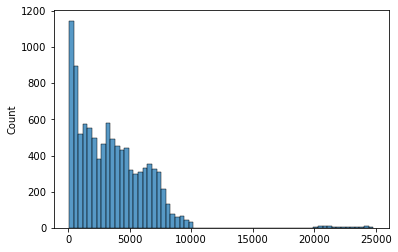

In [15]:
statistical_analysiss(list(dfs['sum_pay']))

In [16]:
dfs = dfs[dfs['sum_pay']< 20000]

In [17]:
test = dfs[dfs['id_group'] == 'test']['sum_pay']
control = dfs[dfs['id_group'] == 'control']['sum_pay']


Среднее =  3339.535408560311
Дисперсия =  5253689.135348443
Стандартное отклонение =  2292.0927414370567
Размах =  3575.75
Decile number 1.0  =  420.0
First quartile =  1281.75
Decile number 3.0  =  1618.0
Decile number 4.0  =  2431.3999999999996
Mediane =  3247.5
Decile number 6.0  =  3848.4
Third quartile =  4857.5
Decile number 9.0  =  6721.0
Quantile 0.91  =  6900.49
Quantile 0.92  =  7043.280000000001
Quantile 0.93  =  7180.0
Quantile 0.94  =  7303.299999999999
Quantile 0.95  =  7459.1
Quantile 0.96  =  7672.44
Quantile 0.97  =  7932.83
Quantile 0.98  =  8207.760000000002
Quantile 0.99  =  8644.319999999996
Quantile 0.995  =  8994.455000000009


(3339.535408560311, 5253689.135348443, 2292.0927414370567)

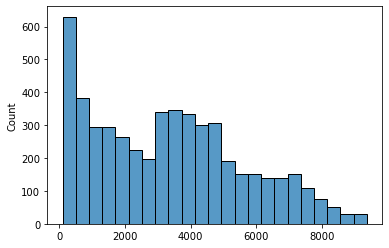

In [18]:
statistical_analysiss(list(control))

Среднее =  3478.955879494655
Дисперсия =  7019364.588449596
Стандартное отклонение =  2649.408346867201
Размах =  4721.0
Decile number 1.0  =  369.0
First quartile =  1089.0
Decile number 3.0  =  1412.0
Decile number 4.0  =  2101.0
Mediane =  2916.0
Decile number 6.0  =  3897.6000000000004
Third quartile =  5810.0
Decile number 9.0  =  7273.200000000001
Quantile 0.91  =  7382.48
Quantile 0.92  =  7488.4800000000005
Quantile 0.93  =  7628.84
Quantile 0.94  =  7755.719999999999
Quantile 0.95  =  7883.8
Quantile 0.96  =  8104.439999999999
Quantile 0.97  =  8593.480000000003
Quantile 0.98  =  9135.0
Quantile 0.99  =  9599.560000000001
Quantile 0.995  =  9841.359999999997


(3478.955879494655, 7019364.588449596, 2649.408346867201)

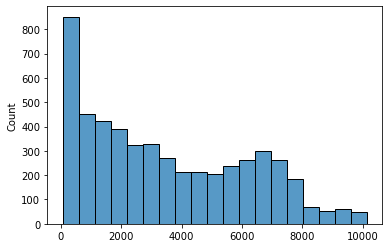

In [19]:
statistical_analysiss(list(test))

(array([[1269.,  765.,  630.,  493.,  426.,  417.,  550.,  390.,  100.,
          105.],
        [1114.,  735.,  563.,  855.,  755.,  375.,  357.,  270.,   97.,
           19.]]),
 array([   59. ,  1067.2,  2075.4,  3083.6,  4091.8,  5100. ,  6108.2,
         7116.4,  8124.6,  9132.8, 10141. ]),
 <a list of 2 BarContainer objects>)

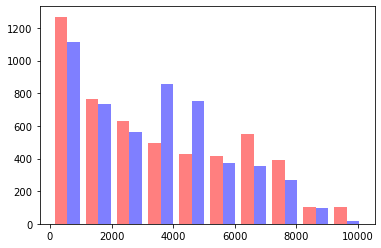

In [20]:
plt.hist([test, control], color=['r','b'], alpha=0.5)

In [21]:
def show_hist (t,c):
    plt.hist([t, c], color=['r','b'], alpha=0.5)
    plt.title('Гистограмма распределения')
    print (show_hist)

<function show_hist at 0x000002048A2DA160>


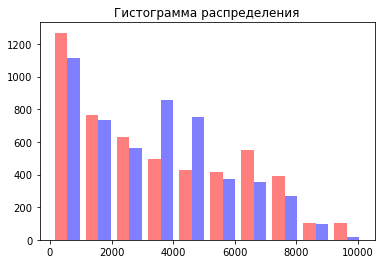

In [22]:
t = test
c = control
show_hist(t,c)

In [23]:
def mann_whitney_func (b1, b2, alpha = 0.05):
    stat, p = stats.mannwhitneyu(x= b1, y= b2, alternative = 'greater')  
    
    if p < alpha:
        print('По Манну-Уитни распределения не равны')
    else:
        print('По Манну-Уитни распределения равны')
    return stat, p
    
   

In [24]:
b1 = test
b2 = control
mann_whitney_func (b1,b2)


По Манну-Уитни распределения равны


(13307632.5, 0.2862263471406218)

5. Примените к этим рядам также t-test для сравнения средних.

In [25]:
from scipy.stats import ttest_ind

In [26]:
def ttest (t1, t2):
      
    s,p = ttest_ind(t1, t2)
    print("p-value = ",p)
    print("t-критерий = ",s)
    print('среднее группы test = ', t1.mean())
    print('среднее группы control = ', t2.mean())
    sns.histplot(t1, color = 'r')
    sns.histplot(t2, color = 'b')
    plt.show()
    
    if p < alpha:
        print("Нулевая гипотеза о равенстве средних не принимается ")
    else:
        print("Нулевая гипотеза о равенстве средних принимается ")
    

p-value =  0.0043287276989780535
t-критерий =  2.8537908222421335
среднее группы test =  3478.955879494655
среднее группы control =  3339.535408560311


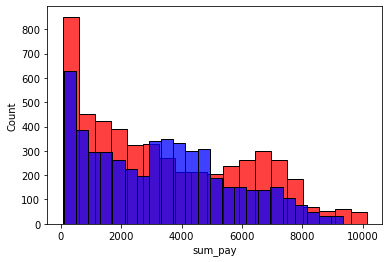

Нулевая гипотеза о равенстве средних не принимается 


In [27]:
alpha = 0.05
t1 = test
t2 = control

ttest (t1,t2)

Низкий p-value дает нам основания отклонить нулевую гипотезу и считать, что есть разница между тестовой и контрольной группами.

2. Анализ по торговым точкам

In [28]:
def point (point):
    point_T = dfs.loc[(dfs['id_group'] == 'test') & (dfs['id_point'] == point)]
    point_C = dfs.loc[(dfs['id_group'] == 'control') & (dfs['id_point'] == point)]
    print(f'Результат для торговой точки № {point}')
    
    ttest(point_T['sum_pay'], point_C['sum_pay'])
    mann_whitney_func(point_T['sum_pay'], point_C['sum_pay'])
    return

Результат для торговой точки № 1182.0
p-value =  1.0387447468996453e-12
t-критерий =  7.172588995409098
среднее группы test =  4945.12947368421
среднее группы control =  4036.9426877470355


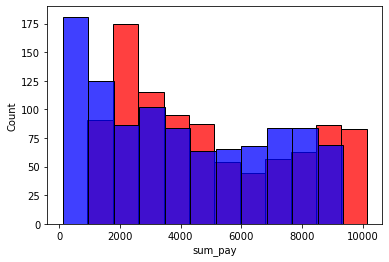

Нулевая гипотеза о равенстве средних не принимается 
По Манну-Уитни распределения не равны
None
Результат для торговой точки № 1178.0
p-value =  0.1251217226713009
t-критерий =  -1.5338932633911708
среднее группы test =  2936.386949293433
среднее группы control =  3036.214731585518


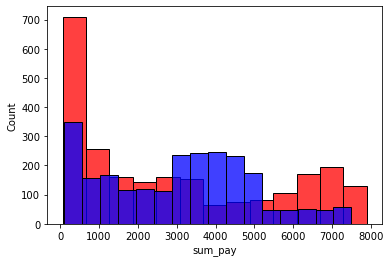

Нулевая гипотеза о равенстве средних принимается 
По Манну-Уитни распределения равны
None
Результат для торговой точки № 1179.0
p-value =  0.2617037465196552
t-критерий =  1.1225576641441302
среднее группы test =  3421.826934097421
среднее группы control =  3331.3105480259283


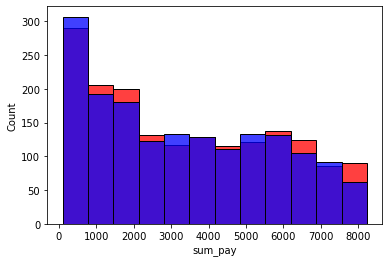

Нулевая гипотеза о равенстве средних принимается 
По Манну-Уитни распределения равны
None
Результат для торговой точки № 1186.0
p-value =  0.181936501831722
t-критерий =  -1.3502123367588006
среднее группы test =  3638.4
среднее группы control =  4546.0


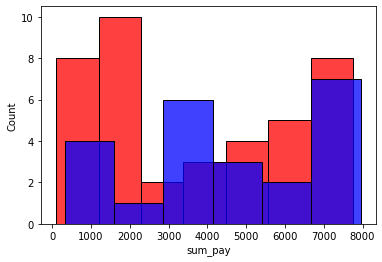

Нулевая гипотеза о равенстве средних принимается 
По Манну-Уитни распределения равны
None
Результат для торговой точки № 1188.0
p-value =  0.8956790614998074
t-критерий =  -0.13596158621984006
среднее группы test =  4946.0
среднее группы control =  5202.0


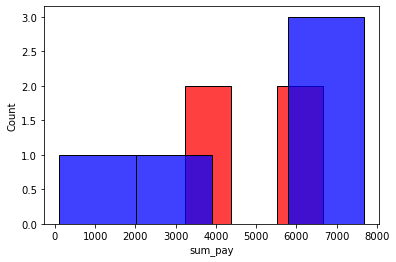

Нулевая гипотеза о равенстве средних принимается 
По Манну-Уитни распределения равны
None


In [29]:
id_point_list = dfs['id_point'].unique().tolist()
for i in id_point_list:
    print(point(i))

ВЫВОД: Анализ торговых точек выявил разногласия: Опираясь на достаточное количество наблюдений можем принять результаты 3 торговых точек, а именно №№ 1178, 1179, 1182. По торговой точке № 1182 нулевая гипотеза не подтвердилась, p-value очень низкий, распределения по Манну-Уитни не равны. По остальным точкам Нулевая гипотеза принимается. 

In [30]:
dfs.groupby('months_reg')['id_client'].count()# количество клиентов по длительности регистрации

months_reg
0      781
1      769
2     1300
3     1607
4     1000
5     1124
6     1182
7      606
8      634
9      294
10     305
11     321
12     210
13      71
14      81
Name: id_client, dtype: int64

In [31]:
test_s = dfs[dfs['id_group'] == 'test']['sum_pay']
test_m = dfs[dfs['id_group'] == 'test']['months_reg']
control_s = dfs[dfs['id_group'] == 'control']['sum_pay']
control_m = dfs[dfs['id_group'] == 'control']['months_reg']

In [32]:
def proxi_ranges (t1, t2, alpha = 0.05):
      
    cov_1 = np.cov(t1, t2)
    cov_2 = np.cov(t1, t2)[0,1]
    
    print("Дисперсия рядa 1 = ", cov_1[0,0])
    print("Дисперсия рядa 2 = ", cov_1[1,1])     
    print("Ковариация = ",cov_2)
    
    pearson_coef,pearson_p = stats.pearsonr(t1, t2)
    spearman_coef,spearman_p = spearmanr(t1, t2)
    
    if pearson_p < alpha:
        print('Корреляция Пирсона равна',pearson_coef )
        if abs (pearson_coef) < 0.3:
            print('Корреляция Пирсона слабая')
        if abs (pearson_coef) < 0.7:
            print('Корреляция Пирсона средняя')
        else:
            print('Корреляция Пирсона сильная')
    else:
        print ("Корреляция Пирсона равна 0")
    print()
    if spearman_p < alpha:
        print('Корреляция Спирмена равна',spearman_coef )
        if abs (spearman_coef) < 0.3:
            print('Корреляция Спирмена слабая')
        if abs (spearman_coef) < 0.7:
            print('Корреляция Спирмена средняя')
        else:
            print('Корреляция Спирмена сильная')
    else:
        print ("Корреляция Спирмена равна 0")
    
    

Корреляция между выплаченной суммой и длительностью регистрации в тестовой группе

Дисперсия рядa 1 =  7019364.588449581
Дисперсия рядa 2 =  10.608658242234911
Ковариация =  5363.91696690229
Корреляция Пирсона равна 0.6215884223650022
Корреляция Пирсона средняя

Корреляция Спирмена равна 0.6694676749072025
Корреляция Спирмена средняя


<AxesSubplot:xlabel='sum_pay', ylabel='months_reg'>

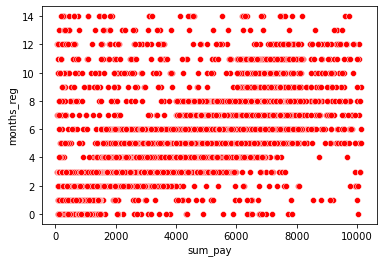

In [33]:
arr_1 = np.array(test_s)
arr_2 = np.array(test_m)
proxi_ranges (arr_1, arr_2)

sns.scatterplot(x = test_s, y = test_m, color = 'r')

Корреляция между выплаченной суммой и длительностью регистрации в контрольной группе

Дисперсия рядa 1 =  5253689.135348442
Дисперсия рядa 2 =  9.69985269431971
Ковариация =  4161.881881212033
Корреляция Пирсона равна 0.5830086454559582
Корреляция Пирсона средняя

Корреляция Спирмена равна 0.6385804587227423
Корреляция Спирмена средняя


<AxesSubplot:xlabel='sum_pay', ylabel='months_reg'>

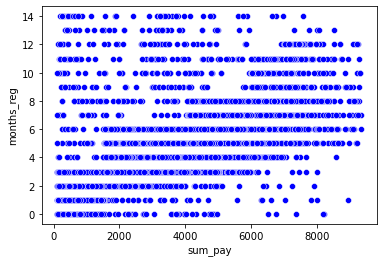

In [34]:
arr_1 = np.array(control_s)
arr_2 = np.array(control_m)
proxi_ranges (arr_1, arr_2)

sns.scatterplot(x = control_s, y = control_m, color = 'b')

ВЫВОД по корреляционному анализу: Между выплаченной суммой и длительностью регистрации в обеих группах существует положительная средняя связь.

ОБЩИЙ ВЫВОД: Проверка эффективности рекламной акции показала положительный результат. При малом количестве экспериментов тестирование не выявляет разницы, хотя на самом деле при увеличении выборки по нескольким торговым точкам тестовая рекламная акция показывает хорошие результаты. проверка выявления связи между выплаченными суммами и длительностью регистрации пользователей выявила среднюю положительную степень зависимости.